In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})


In [2]:
from scipy.constants import e, m_p, c

from scipy.constants import physical_constants

In [3]:
from cpymad.madx import Madx

import pysixtracklib as pyst

In [4]:
nmass = physical_constants['atomic mass constant energy equivalent in MeV'][0] * 1e-3
nmass = 0.931494061 # MAD-X value

# Load linear MAD-X lattice for SIS100 (cold quads only)

In [5]:
madx = Madx()
madx.options.echo = False


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.04.02  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2018.10.03               +
  + Execution date: 2019.05.28 14:04:20      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [6]:
madx.call(file="./2019-05-24--100turns-onlyquad/beam-distr.madx")

In [7]:
madxwarn = madx.options.warn
madx.options.warn = False
#madx.call(file=filename_error_table + '_full-lattice.seq')
# madx.call(file='./2019-05-23--100turns/SIS100RING_220618_nodipedge.thin.seq')
madx.call(file='./2019-05-24--100turns-onlyquad/SIS100QUADS.thin.seq')
madx.options.warn = madxwarn

In [8]:
madx.command.beam(particle='proton', energy=1)

True

In [9]:
madx.input('value, beam%sis100quads->gamma;')

beam%sis100quads->gamma =        1.065788933 ;


True

In [10]:
madx.input('value, beam%sis100quads->mass;')

beam%sis100quads->mass =       0.9382720813 ;


True

In [11]:
nmass_p = m_p/e*c**2
#nmass_p = 0.9382720813 * 1e9
nmass_p

938272081.4796857

In [12]:
Ekin = np.sqrt(1e9**2 - nmass_p**2)

In [13]:
# gamma recomputed to compare
np.sqrt((np.sqrt(1e9**2 - nmass_p**2) / nmass_p)**2 + 1)

1.065788932377661

In [14]:
madx.use(sequence='SIS100QUADS')

In [15]:
madx.input(
'''match, sequence=SIS100QUADS;
global, sequence=SIS100QUADS, q1=18.88, q2=18.88;
vary, name = kqf, step=0.0001;
vary, name = kqd, step=0.0001;
lmdif, tolerance=1e-20;
endmatch;
''')

START MATCHING

number of sequences: 1
sequence name: sis100quads
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   4.14120421e-24





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
kqf                       1.92906e-01  1.92906e-01 -1.00000e+20  1.00000e+20
kqd                      -1.92906e-01 -1.92906e-01 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   4.14120421e-24


True

In [16]:
madx.use(sequence='SIS100QUADS')

In [17]:
twiss = madx.twiss();

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0   -3.330669074e-16       -54794158.01 

                q1                dq1            betxmax              dxmax 
             18.88       -65.92076628        19.86530221                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0              18.88 

               dq2            betymax              dymax              dyrms 
      -65.92076628         19.8653033                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [18]:
sis100 = madx.sequence.SIS100QUADS

In [19]:
[f.name for f in map(lambda x: x.base_type, sis100.expanded_elements) 
 if 'drift' != f.name and 'multipole' != f.name and 'rfcavity' != f.name]

['marker', 'marker']

# Create MAD-X tracking files for comparison

In [20]:
nturns = 100 #2**16

In [21]:
madx.input('''
epsx_gauss=35e-6/4;
epsy_gauss=15e-6/4;
number_particles = 1000;
number_turns={:d};
ffile_stat=100;
gauss_cut=2;
'''.format(nturns))

True

### 100 turns:

In [22]:
madx.input("""
COPTION, SEED=987456321, PRINT=2;""")

True

In [23]:
madx.input('''
track, onepass,onetable;

n=0;
while(n<number_particles)
{
    exec, 6D_beam(gauss_cut,twiss);
    n=n+1;
}

run,turns=number_turns,ffile=ffile_stat;
endtrack;
''')

enter TRACK module
one pass is on
exit TRACK module



True

In [24]:
madx.command.write(table='tracksumm', file='madx_tracking_100turns.out')

True

### one turn, element by element:

In [25]:
madx.input("""
COPTION, SEED=987456321, PRINT=2;""")

True

In [26]:
madx.input('''
track, onepass, onetable, file=madx_tracking_oneturn.out;
'''
)

for elem_name in sis100.element_names()[1:-1]:
    madx.command.observe(place=elem_name)

madx.input('''
n=0;
while(n<number_particles)
{
    exec, 6D_beam(gauss_cut,twiss);
    n=n+1;
}

run,turns=1,ffile=1;
endtrack;
''')

enter TRACK module
one pass is on
exit TRACK module



True

# Load lattice and create beam in PySTL

In [27]:
elements = pyst.Elements.from_mad(sis100)

In [28]:
len(elements.get_elements())

339

In [29]:
elements.BeamMonitor(num_stores=1);

In [30]:
p0c = Ekin #238*0.2 * 1e9

In [31]:
npart = 1000
particles = pyst.Particles.from_ref(npart, p0c=p0c) #, q0=28, mass0=238*nmass*1e9)

In [32]:
particles.gamma0[0]

1.0657889324020815

In [33]:
madx.command.value('beam->gamma;')

beam->gamma        =        1.065788933 ;


True

# Load MAD-X tracking results, write initial coordinates into PySTL particles

In [34]:
filename_tracksumm = './madx_tracking_100turns.out'

In [35]:
initial_distribution = np.genfromtxt(
    filename_tracksumm, skip_header=8, max_rows=1000)

In [36]:
headers = list(np.genfromtxt(
    filename_tracksumm, skip_header=6, max_rows=1, dtype=str)[1:])

In [37]:
initial_distribution.shape

(1000, 10)

In [38]:
final_distribution = np.genfromtxt(
    filename_tracksumm, skip_header=8 + 1000,)

In [39]:
final_distribution.shape

(1000, 10)

In [40]:
assert final_distribution.shape == initial_distribution.shape

In [41]:
assert final_distribution[0, 1] == nturns

In [42]:
np.genfromtxt('./madx_tracking_oneturn.outone', skip_header=54).shape

(170000, 10)

In [43]:
x = initial_distribution[:, headers.index('X')]
xp = initial_distribution[:, headers.index('PX')]
y = initial_distribution[:, headers.index('Y')]
yp = initial_distribution[:, headers.index('PY')]
z = initial_distribution[:, headers.index('T')] * particles.beta0
dp = initial_distribution[:, headers.index('PT')] / particles.beta0**2

In [44]:
print ('sig_x: {}\nsig_y: {}\nsig_z: {}\nsig_dp: {}'.format(
    np.std(x), np.std(y), np.std(z), np.std(dp)))

sig_x: 0.008567296814283466
sig_y: 0.00345077169709805
sig_z: 0.0
sig_dp: 0.0


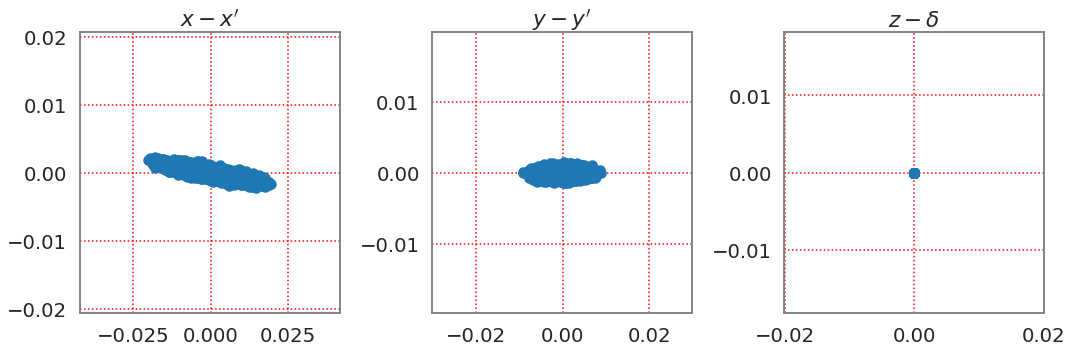

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt.sca(ax[0])
plt.title('$x-x\'$')
plt.scatter(x, xp)

plt.sca(ax[1])
plt.title('$y-y\'$')
plt.scatter(y, yp)

plt.sca(ax[2])
plt.title('$z-\delta$')
plt.scatter(z, dp)
plt.tight_layout()

In [46]:
particles.x *= 0
particles.px *= 0
particles.y *= 0
particles.py *= 0
particles.zeta *= 0
particles.delta *= 0

particles.x += x
particles.px += xp
particles.y += y
particles.py += yp
particles.zeta += z
particles.delta += dp

# PySTL tracking and comparison to MAD-X

### 1. element-by-element tracking for a single turn

In [47]:
job = pyst.TrackJob(elements, particles, device="opencl:1.0", until_turn_elem_by_elem=True)

In [48]:
job.track_elem_by_elem(1)

0

In [49]:
job.collect()

In [50]:
s = twiss['s'][::2]
beta_x = twiss['betx'][::2]
beta_y = twiss['bety'][::2]

p_id = 1

In [51]:
rec_x = job.output.particles[0].x
rec_y = job.output.particles[0].y

x_pystl = rec_x[p_id::npart][1:][::2]
y_pystl = rec_y[p_id::npart][1:][::2]

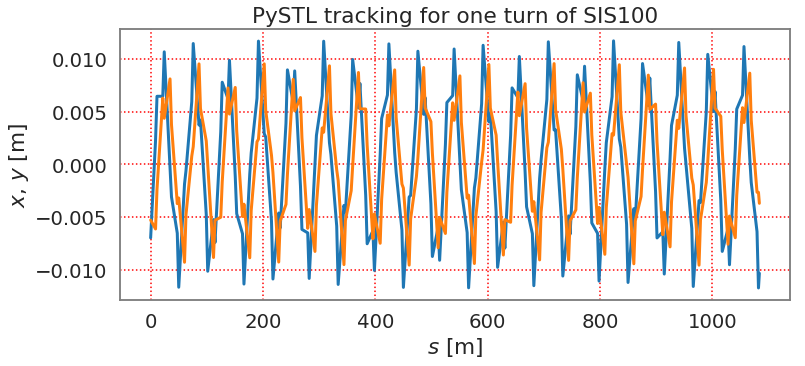

In [52]:
plt.figure(figsize=(12, 5))
plt.title('PySTL tracking for one turn of SIS100')
plt.xlabel('$s$ [m]')
plt.ylabel('$x$, $y$ [m]')
plt.plot(s, x_pystl)
plt.plot(s, y_pystl);

In [53]:
madx_ebye = np.genfromtxt('./madx_tracking_oneturn.outone', skip_header=54)

In [54]:
madx_ebye_headers = list(np.genfromtxt(
    './madx_tracking_oneturn.outone', skip_header=51, max_rows=1, dtype=str)[1:])

In [55]:
madx_ebye_elems = madx_ebye.reshape((len(sis100.elements), npart, madx_ebye.shape[1]))

In [56]:
x_madx = madx_ebye_elems[:, p_id, madx_ebye_headers.index('X')]
y_madx = madx_ebye_elems[:, p_id, madx_ebye_headers.index('Y')]

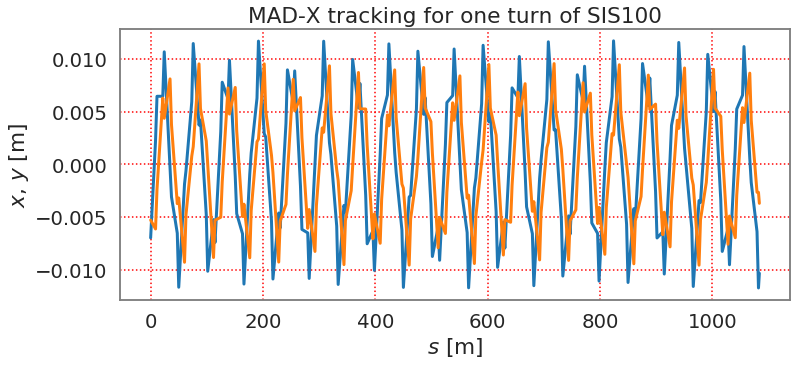

In [57]:
plt.figure(figsize=(12, 5))
plt.title('MAD-X tracking for one turn of SIS100')
plt.xlabel('$s$ [m]')
plt.ylabel('$x$, $y$ [m]')
plt.plot(s, x_madx)
plt.plot(s, y_madx);

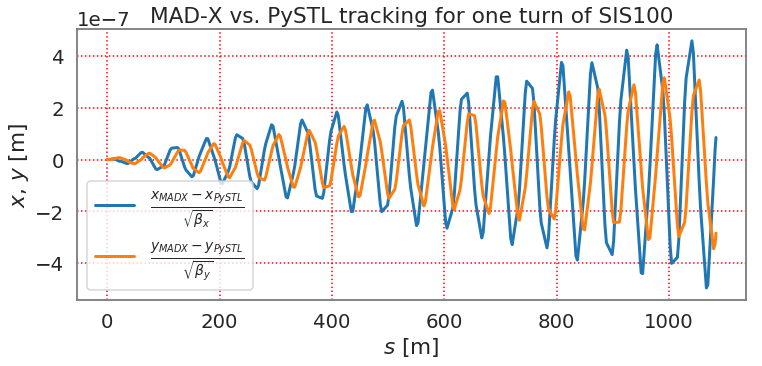

In [58]:
plt.figure(figsize=(12, 5))
plt.title('MAD-X vs. PySTL tracking for one turn of SIS100')
plt.xlabel('$s$ [m]')
plt.ylabel('$x$, $y$ [m]')
plt.plot(s, (x_madx - x_pystl) / np.sqrt(beta_x), label=r'$\frac{x_{MADX} - x_{PySTL}}{\sqrt{\beta_x}}$')
plt.plot(s, (y_madx - y_pystl) / np.sqrt(beta_y), label=r'$\frac{y_{MADX} - y_{PySTL}}{\sqrt{\beta_y}}$')
plt.legend();
plt.savefig('tracking_madx_vs_pystl_optics-normalised.pdf', bbox_inches='tight')

### 2. `nturns` tracking

In [59]:
elements = pyst.Elements.from_mad(sis100)
elements.BeamMonitor(num_stores=nturns)

particles = pyst.Particles.from_ref(npart, p0c=p0c)

particles.x *= 0
particles.px *= 0
particles.y *= 0
particles.py *= 0
particles.zeta *= 0
particles.delta *= 0

particles.x += x
particles.px += xp
particles.y += y
particles.py += yp
particles.zeta += z
particles.delta += dp

In [60]:
job = pyst.TrackJob(elements, particles, device="opencl:1.0")

In [61]:
job.track(nturns)

0

In [62]:
job.collect()

In [63]:
rec_x = job.output.particles[0].x
rec_y = job.output.particles[0].y

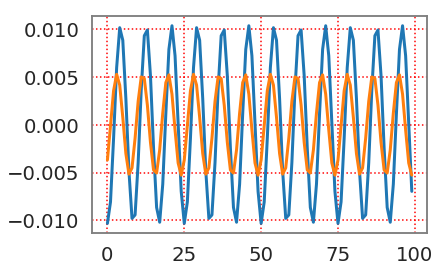

In [64]:
plt.plot(rec_x[1::npart])
plt.plot(rec_y[1::npart])

In [65]:
pbuffer = job.particles_buffer.get_object(0)

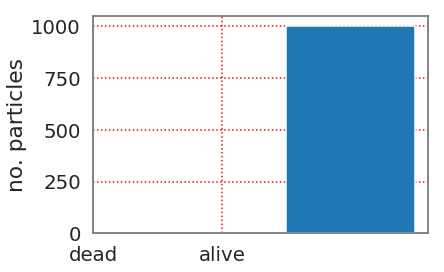

In [66]:
plt.hist(pbuffer.state, bins=2);
plt.ylabel('no. particles')
plt.xticks(ticks=[0.25, 0.75], labels=['dead', 'alive']);

In [67]:
# plt.title('fixed global aperture')
# plt.hist(pbuffer.at_element[~pbuffer.state.astype(bool)]);
# plt.ylabel('no. particles')
# plt.xlabel('no. element of loss');

In [68]:
# plt.hist(pbuffer.at_turn[~pbuffer.state.astype(bool)], bins=25);
# plt.yscale('log')
# plt.ylabel('no. particles')
# plt.xlabel('turn number of loss');

In [69]:
Qx = twiss.summary['q1']
qx = Qx % 1
qx = qx if qx < 0.5 else 1 - qx

Qy = twiss.summary['q2']
qy = Qy % 1
qy = qy if qy < 0.5 else 1 - qy

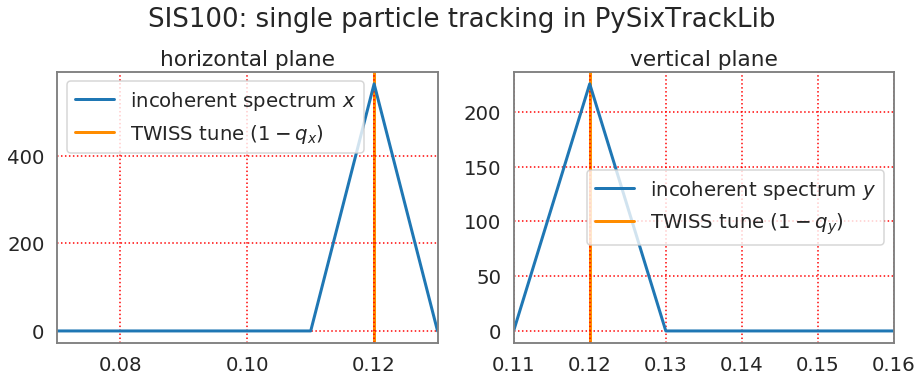

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

plt.sca(ax[0])
plt.title('horizontal plane')
plt.plot(
    np.fft.rfftfreq(len(rec_x[1::npart])),
    np.sum(np.abs(np.fft.rfft(rec_x.reshape(nturns, npart).T, axis=1)), axis=0),
    label=r'incoherent spectrum $x$'
)
plt.axvline(qx, color='darkorange', zorder=-1,
            label='TWISS tune $(1-q_x)$')
plt.xlim(qx - 0.05, qx + 0.01)
plt.legend()

plt.sca(ax[1])
plt.title('vertical plane')
plt.plot(
    np.fft.rfftfreq(len(rec_y[1::npart])),
    np.sum(np.abs(np.fft.rfft(rec_y.reshape(nturns, npart).T, axis=1)), axis=0),
    label=r'incoherent spectrum $y$'
)
plt.axvline(qy, color='darkorange', zorder=-1,
            label='TWISS tune $(1-q_y)$')
plt.xlim(qy - 0.01, qy + 0.04)
plt.legend()

plt.suptitle('SIS100: single particle tracking in PySixTrackLib', y=1.06, fontsize=26);
# plt.savefig('./pystl_sis100_tunes.pdf', bbox_inches='tight')

In [71]:
x = final_distribution[:, headers.index('X')]
xp = final_distribution[:, headers.index('PX')]
y = final_distribution[:, headers.index('Y')]
yp = final_distribution[:, headers.index('PY')]
z = final_distribution[:, headers.index('T')] * particles.beta0
dp = final_distribution[:, headers.index('PT')] / particles.beta0**2

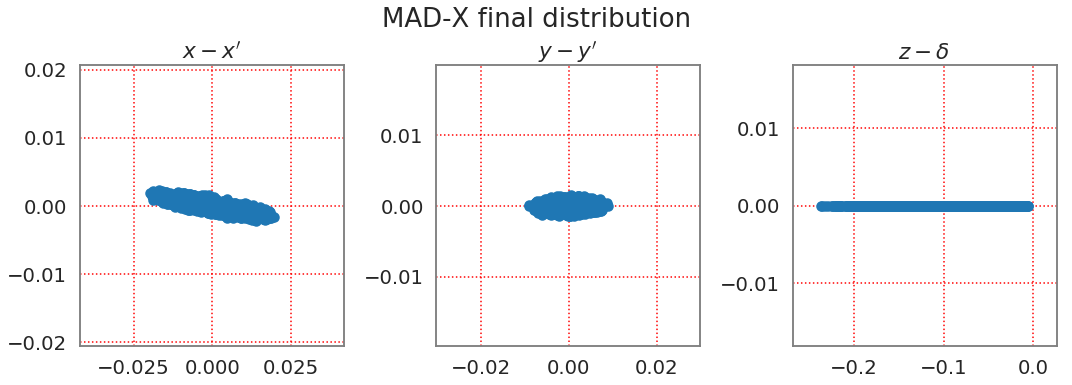

In [72]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt.suptitle('MAD-X final distribution', fontsize=26, y=1.06)

plt.sca(ax[0])
plt.title('$x-x\'$')
plt.scatter(x, xp)

plt.sca(ax[1])
plt.title('$y-y\'$')
plt.scatter(y, yp)

plt.sca(ax[2])
plt.title('$z-\delta$')
plt.scatter(z, dp)
plt.tight_layout()

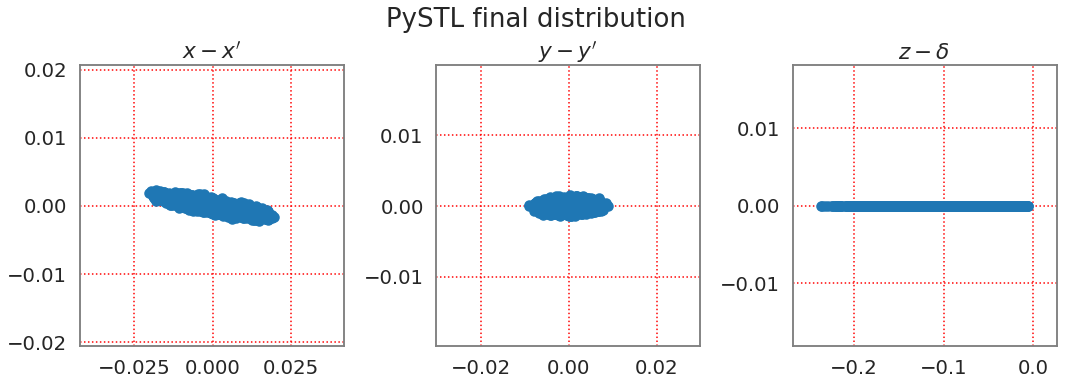

In [73]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt.suptitle('PySTL final distribution', fontsize=26, y=1.06)

plt.sca(ax[0])
plt.title('$x-x\'$')
plt.scatter(pbuffer.x, pbuffer.px)

plt.sca(ax[1])
plt.title('$y-y\'$')
plt.scatter(pbuffer.y, pbuffer.py)

plt.sca(ax[2])
plt.title('$z-\delta$')
plt.scatter(pbuffer.zeta, pbuffer.delta)
plt.tight_layout()

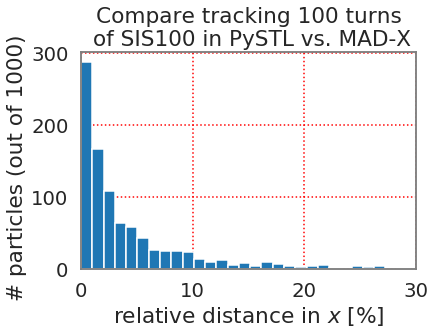

In [74]:
plt.hist(
    np.abs((pbuffer.x - final_distribution[:, headers.index('X')]) / pbuffer.x) * 100, 
    bins=np.linspace(0, 100, 100));
plt.xlim(0, 30)
plt.xlabel('relative distance in $x$ [%]')
plt.ylabel('# particles (out of {})  '.format(npart));
plt.title('Compare tracking 100 turns\n of SIS100 in PySTL vs. MAD-X')
plt.savefig('./tracking_madx_vs_pystl_x.pdf', bbox_inches='tight');

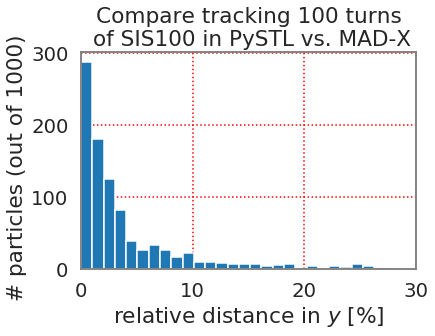

In [75]:
plt.hist(
    np.abs((pbuffer.y - final_distribution[:, headers.index('Y')]) / pbuffer.y) * 100, 
    bins=np.linspace(0, 100, 100));
plt.xlim(0, 30)
plt.xlabel('relative distance in $y$ [%]')
plt.ylabel('# particles (out of {})  '.format(npart));
plt.title('Compare tracking 100 turns\n of SIS100 in PySTL vs. MAD-X')
plt.savefig('./tracking_madx_vs_pystl_y.pdf', bbox_inches='tight');

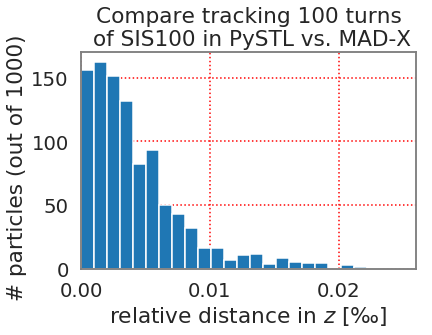

In [76]:
plt.hist(
    np.abs((pbuffer.zeta - final_distribution[:, headers.index('T')] * particles.beta0) / pbuffer.zeta) * 1000, 
    bins=np.linspace(0, 0.1, 100));
plt.xlim(0, 0.026)
plt.xlabel(u'relative distance in $z$ [‰]')
plt.ylabel('# particles (out of {})  '.format(npart));
plt.title('Compare tracking 100 turns\n of SIS100 in PySTL vs. MAD-X')
plt.savefig('./tracking_madx_vs_pystl_z.pdf', bbox_inches='tight');